# 6. Boosting algortihms

This notebook will show applications of boosting algorithms on the dataset [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) available in Kaggle. It contains about 10 years of daily weather observations from many locations across Australia.

### Index:
1. [Packages required](#1.-Packages-required)
2. [Loading data](#2.-Loading-data)
3. [AdaBoost](#3.-AdaBoost)
4. [Gradient Boosting](#4.-Gradient-Boosting)
5. [XGBoost](#5.-XGBoost)
6. [LightGBM](#6.-LightGBM)
7. [CatBoost](#7.-CatBoost)
8. [Conclusions](#8.-Conclusions)

# 1. Packages required

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

# 2. Loading data

In [14]:
weather = pd.read_parquet('../data/04_model_input/master.parquet')
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Location.Walpole,Location.Hobart,Location.Launceston,Location.AliceSprings,Location.Darwin,Location.Katherine,Location.Uluru,WindGustDir_encoded,WindDir9am_encoded,WindDir3pm_encoded
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,0,0,0,0,0,0,0,12.0,12.0,13.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,0,0,0,0,0,0,0,13.0,15.0,11.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,0,0,0,0,0,0,0,11.0,12.0,11.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,0,0,0,0,0,0,0,2.0,6.0,4.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,0,0,0,0,0,0,0,12.0,3.0,14.0


In [3]:
#We fix the variables we are interested in and the date to separate data:
test_date = '2015-01-01'

model_columns = list(set(weather.select_dtypes(include='number').columns) - set(['RainTomorrow']))

In [4]:
#We separate in train/test data and solve Nan problems:
train = weather[weather.Date < test_date].fillna(-1)
test = weather[weather.Date >= test_date].fillna(-1)

# 3. AdaBoost

AdaBoost is a boosting algorithm that reduces the prediction error building (sequentially) trees with only two leave nodes. According to the error from the last estimator, the sample weights are changed and the trees are generated taking into account these different weights.

The Python implementation allows you to modify the base estimator, but we won't modify it to use the original one ("base_estimator = None" is a decision tree with max_depth = 1). Also, to avoid overfitting, we will use a learning rate $\nu = 0.1$

Then, we will generate different model with different number of boosting iterations to see the evolution.

In [5]:
#We generate our AdaBoost algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = 0.1)
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['AdaB_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_AdaB = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_AdaB['delta%'] = 100*(metrics_AdaB.Test_Gini - metrics_AdaB.Train_Gini) / metrics_AdaB.Train_Gini
metrics_AdaB

,Run_Time,Train_Gini,Test_Gini,delta%
AdaB_1,0.722178,0.356810,0.324403,-9.082368
AdaB_3,1.164307,0.435319,0.394087,-9.471638
AdaB_5,1.813876,0.540856,0.518804,-4.077312
AdaB_10,3.015537,0.569703,0.540461,-5.132848
AdaB_15,4.922291,0.616769,0.573879,-6.953917
AdaB_20,6.746149,0.644189,0.607569,-5.684610
AdaB_30,8.926050,0.663490,0.625806,-5.679689
AdaB_50,15.353484,0.690590,0.660897,-4.299631
AdaB_100,30.408968,0.709561,0.690381,-2.703051
AdaB_200,59.428710,0.725838,0.710970,-2.048381


In [6]:
metrics_AdaB.to_parquet('../data/models/adab.parquet')

# 4. Gradient Boosting

Gradient Boosting is another boosting algorithm. While AdaBoost modifies the sample weights to build the trees, Gradient Boosting computes the residuals and try to classify them. By this way, the model starts with a big error but the more iterations you make the less error you will be comitting. Also, other difference between AdaBoost and Gradient Boosting is the fact that AdaBoost (originally) builds trees with only two leave nodes and Gradient Boost doesn't have a predetermined number of leaves.

About the parameters that we will choose to build our model:
* Loss function: loss = log_loss (default), that it's the same that we have been studying at the project.
* Learning rate: learning_rate = 0.1 (default), that it's the most common value to avoid overfitting.
* Error measure: criterion = mse, that it's the same that we have been studying.
* Tree depth: max_depth = 5, that it's the same that we fix in bagging. We fix it to, later, do good comparisons

Also, we will generate models with different numbers of iterations (n_estimators) to compare them and see clearly the evolution.

In [7]:
#We generate our Gradient Boosting algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = GradientBoostingClassifier(max_depth = 5, n_estimators = n_estimators, criterion = 'mse' )
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['GB_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_GB = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_GB['delta%'] = 100*(metrics_GB.Test_Gini - metrics_GB.Train_Gini) / metrics_GB.Train_Gini
metrics_GB

,Run_Time,Train_Gini,Test_Gini,delta%
GB_1,1.337438,0.655905,0.626416,-4.496019
GB_3,2.832879,0.689842,0.659179,-4.444932
GB_5,4.255035,0.699742,0.671312,-4.062962
GB_10,8.393019,0.716041,0.689299,-3.734701
GB_15,12.450471,0.728727,0.704053,-3.385928
GB_20,15.714619,0.739507,0.714385,-3.397137
GB_30,22.324615,0.754659,0.727578,-3.588536
GB_50,38.503903,0.776301,0.744640,-4.078426
GB_100,74.578835,0.801266,0.758892,-5.288423
GB_200,158.102776,0.828853,0.769328,-7.181574


In [8]:
metrics_GB.to_parquet('../data/models/gb.parquet')

# 5. XGBoost

XGBoost is the abbreviation of 'e**X**treme **G**radient **Boost**ing' and is a boosting method based on the last one. XGBoost models apply Gradient Boosting using their own type of trees, which are built taking into account the gradient and the hessian of the Loss Function and some regularization parameters. Also, XGBoost has many computational advantages to do the task faster.

XGBoost is a algorithm with a lot of parameters: regularization parameters, maximum depth of the trees, number of iterations, minimum number of subjects in the node to divide it ... That's very useful because it allows you to modify the algorithm as you want. However, to show a basic example, we will use many of the default values and:
* Learning rate: eta = 0.1, that it's a typical value for the learning rate and it's the same that we used in other models.
* $\gamma$: gamma = 0 (default), that it's one of the regularization parameters studied in the project.
* $\lambda$: lambda = 1 (default), that it's the other regularization parameter studied.
* Build method: tree_method = auto (default), that chooses the optimal method according to the length of the data. We have different methods based on the optimizations commented at the project.
* Tree depth: max_depth = 5, that it's the same that we fix in bagging. We fix it to, later, do good comparisons

Also, we will generate diffent models changing the number of iterations that the model makes.

In [9]:
#We generate our XGBoost algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = XGBClassifier(max_depth = 5, eta = 0.1, n_estimators = n_estimators )
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['XGB_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_XGB = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_XGB['delta%'] = 100*(metrics_XGB.Test_Gini - metrics_XGB.Train_Gini) / metrics_XGB.Train_Gini
metrics_XGB

,Run_Time,Train_Gini,Test_Gini,delta%
XGB_1,0.477639,0.655905,0.626420,-4.495371
XGB_3,0.611812,0.689479,0.657677,-4.612464
XGB_5,0.643573,0.699951,0.671493,-4.065695
XGB_10,0.860802,0.712462,0.681855,-4.296022
XGB_15,1.081318,0.726696,0.701405,-3.480202
XGB_20,1.289272,0.736408,0.709938,-3.594401
XGB_30,1.716818,0.753343,0.725202,-3.735485
XGB_50,2.605901,0.775598,0.742928,-4.212247
XGB_100,4.794234,0.801095,0.759674,-5.170500
XGB_200,10.367486,0.830706,0.772085,-7.056805


In [10]:
metrics_XGB.to_parquet('../data/models/xgb.parquet')

# 6. LightGBM

LightGBM is the abbreviaton of '**Light** **G**radient **B**oosting **M**achine' and is a algorithm developed by Microsoft. It shares his main characteristics with XGBoost, but it builds the trees dividing the nodes that maximize the gain (uses a 'leaf-wise tree growth'). That becomes in assymetric trees with branches more developed than others. In addition, LightGBM applies a set of computational advantages to make it faster.

The parameters that we will use are equivalent to the parameters defined in XGBoost. Also, we will compare different models with diferent number of estimators too.

In [11]:
#We generate our LightGBM algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = LGBMClassifier(max_depth = 5, n_estimators = n_estimators )
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['LGBM_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_LGBM = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_LGBM['delta%'] = 100*(metrics_LGBM.Test_Gini - metrics_LGBM.Train_Gini) / metrics_LGBM.Train_Gini
metrics_LGBM

,Run_Time,Train_Gini,Test_Gini,delta%
LGBM_1,0.546523,0.655849,0.632815,-3.512204
LGBM_3,0.504272,0.692484,0.663678,-4.159791
LGBM_5,0.516229,0.704912,0.679948,-3.541466
LGBM_10,0.537574,0.720321,0.697072,-3.227545
LGBM_15,0.563205,0.731729,0.708000,-3.242852
LGBM_20,0.593919,0.740490,0.714121,-3.561060
LGBM_30,0.661081,0.757666,0.728752,-3.816289
LGBM_50,0.769436,0.777606,0.744632,-4.240512
LGBM_100,0.919793,0.801667,0.758673,-5.363087
LGBM_200,1.394225,0.832145,0.772247,-7.198036


In [12]:
metrics_LGBM.to_parquet('../data/models/lgbm.parquet')

# 7. CatBoost

CatBoost is the last boosting algorithm studied in the project. His name is the abbreviature of '**Cat**egorical **Boost**ing' and is famous due to the way of deal with categorical variables. These special method allows us to use it directly without encoding the categorical values, so we save preprocessing time.

To use it taking advantage of the characteristic commented, we will use a previous and less preprocessed dataset than in the other examples.

In [17]:
#We fix the new columns that we will take into account to generate the model:
locations = list(weather.Location.unique())
Locations = []
for loc in locations:
    Locations += ['Location.'+str(loc)]
model_columns = list(set(weather.columns) - set(['RainTomorrow', 'Date', 'Location_encoded', 'WindDir3pm_encoded',
                                                 'WindDir9am_encoded', 'WindGustDir_encoded']) - set(Locations))

After removing the encoded variables, we apply the CatBoost algorithm:

In [18]:
#We generate our CatBoost algorithms:
cat_features = list(weather.select_dtypes(include='object').columns) 
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = CatBoostClassifier(n_estimators = n_estimators, cat_features = cat_features, silent = True)
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['CatB_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_CatB = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_CatB['delta%'] = 100*(metrics_CatB.Test_Gini - metrics_CatB.Train_Gini) / metrics_CatB.Train_Gini
metrics_CatB

,Run_Time,Train_Gini,Test_Gini,delta%
CatB_1,1.294094,0.645750,0.619790,-4.020226
CatB_3,1.175735,0.704949,0.674643,-4.298986
CatB_5,1.353958,0.722040,0.705879,-2.238192
CatB_10,1.866378,0.739444,0.721088,-2.482412
CatB_15,2.150091,0.752293,0.729310,-3.054950
CatB_20,2.787717,0.759876,0.733439,-3.479115
CatB_30,3.714761,0.775832,0.741758,-4.391964
CatB_50,5.259317,0.792454,0.749199,-5.458369
CatB_100,9.141006,0.821290,0.754821,-8.093263
CatB_200,24.907089,0.849800,0.778066,-8.441278


In [19]:
metrics_CatB.to_parquet('../data/models/catb.parquet')

# 8. Conclusions

As we can see, the results obtained with this type of algorithms is much better than the result obtained with bagging algorithms or a simple decision tree. In each table, we can find a model whose $delta\%$ is less than $5\%$ and whose Gini coefficient is higher than 0.7, which is a prove of the good accuracy of the model.

On the other hand, we can see that some of this models are overfitted. Thus, when we work with boosting algorithms we have to take into account that the model can overfits and, in this case, change different regularization parameters to avoid it.

In [3]:
metrics_AdaB = pd.read_parquet('../data/models/adab.parquet')
metrics_GB = pd.read_parquet('../data/models/gb.parquet')
metrics_XGB = pd.read_parquet('../data/models/xgb.parquet')
metrics_LGBM = pd.read_parquet('../data/models/lgbm.parquet')
metrics_CatB = pd.read_parquet('../data/models/catb.parquet')

<AxesSubplot:title={'center':'Evolución de delta%'}, xlabel='Número de árboles', ylabel='|delta%|'>

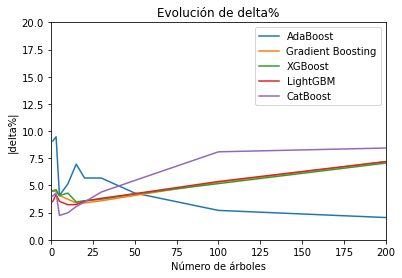

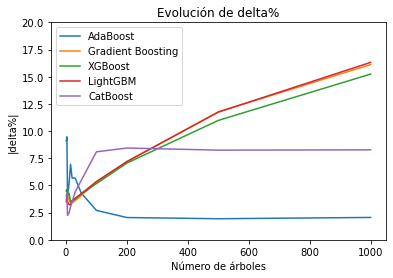

In [4]:
DELTA = pd.DataFrame({'AdaBoost': list(abs(metrics_AdaB['delta%'].values)),
              'Gradient Boosting': list(abs(metrics_GB['delta%'].values)), 
              'XGBoost': list(abs(metrics_XGB['delta%'].values)),
              'LightGBM': list(abs(metrics_LGBM['delta%'].values)),
              'CatBoost':list(abs(metrics_CatB['delta%'].values))}, index = [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000])

DELTA.plot(ylim = [0,20], xlim = [0, 200], xlabel = 'Número de árboles', ylabel = '|delta%|', title = 'Evolución de delta%')
DELTA.plot(ylim = [0,20], xlabel = 'Número de árboles', ylabel = '|delta%|', title = 'Evolución de delta%')